### Define file path

In [1]:
# 파일 경로 설정
import pandas as pd
import os

# PC filepath 설정
BASE_FILEPATH = "/home/songmu/"
# BASE_FILEPATH = "/home/widen/"

# 사용할 client 및 server filepath 설정(연, 월, 일, 시)
CLIENT_FILEPATH = BASE_FILEPATH + "multipath/client/logs/2025_02_17_14_14/"
SERVER_FILEPATH = BASE_FILEPATH + "multipath/server/logs/2025_02_17_13_57/"

# 패킷 수신시 패킷 정보 logging 해둔 filepath
KT_LOG_FILEPATH = SERVER_FILEPATH + "kt_log.csv"
LG_LOG_FILEPATH = SERVER_FILEPATH + "lg_log.csv"
# 위 KT, LG 를 이용하여 만들어줄 Combine traffic의 저장 경로
COMBINE_LOG_FILEPATH = SERVER_FILEPATH + "combine_log.csv"

# 송신측의 패킷 정보 logging 해둔 filepath
SENDING_LOG_FILEPATH = CLIENT_FILEPATH + "logs/packet_log.csv"

# 생성한 그래프들 저장할 filepath
GRAPH_PATH = SERVER_FILEPATH + "graphs"
os.makedirs(GRAPH_PATH, exist_ok = True)

# 생성할 frames 저장할 filepath
FRAMES_FILEPATH = SERVER_FILEPATH + "frames"

### Make combine_log.csv

In [2]:
import pandas as pd
BASE_FILEPATH = "/home/songmu/"

# Read csv files
kt_log_df = pd.read_csv(KT_LOG_FILEPATH, index_col = None)
lg_log_df = pd.read_csv(LG_LOG_FILEPATH, index_col = None)
sending_log_df = pd.read_csv(SENDING_LOG_FILEPATH, index_col = None)

# 두 개의 DataFrame을 sequence_number 기준으로 병합 (outer join, 양쪽 모두에 존재하는 행을 포함)
merged_df = pd.merge(kt_log_df, lg_log_df, on="sequence_number", how="outer", suffixes=('_kt', '_lg'))

# 빈 리스트 생성
combined_data = []

# 같은 sequence_number에서 latency가 적은 row를 선택하고, 마지막 column에 kt 또는 lg 추가
for index, row in merged_df.iterrows():
    if pd.isna(row['network_latency_ms_kt']):  # KT 데이터가 없을 경우 LG 데이터를 사용하고 'lg'를 추가
        combined_data.append([row['source_ip_lg'], row['sequence_number'], row['timestamp_frame_lg'], row['timestamp_sending_lg'], row['received_time_lg'], row['network_latency_ms_lg'], row['message_size_lg'], 'lg'])
    elif pd.isna(row['network_latency_ms_lg']):  # LG 데이터가 없을 경우 KT 데이터를 사용하고 'kt'를 추가
        combined_data.append([row['source_ip_kt'], row['sequence_number'], row['timestamp_frame_kt'], row['timestamp_sending_kt'], row['received_time_kt'], row['network_latency_ms_kt'], row['message_size_lg'], 'kt'])
    else:
        # 두 row 중 latency가 더 작은 것을 선택하고 그에 맞는 label 추가
        if row['network_latency_ms_kt'] < row['network_latency_ms_lg']:
            combined_data.append([row['source_ip_kt'], row['sequence_number'], row['timestamp_frame_kt'], row['timestamp_sending_kt'], row['received_time_kt'], row['network_latency_ms_kt'], row['message_size_kt'], 'kt'])
        else:
            combined_data.append([row['source_ip_lg'], row['sequence_number'], row['timestamp_frame_lg'], row['timestamp_sending_lg'], row['received_time_lg'], row['network_latency_ms_lg'], row['message_size_kt'], 'lg'])

# 결과를 DataFrame으로 변환
combined_log_df = pd.DataFrame(combined_data, columns= ["source_ip", "sequence_number", "timestamp_frame", "timestamp_sending", "received_time", "network_latency_ms", "message_size", "source"])
combined_log_df.to_csv(COMBINE_LOG_FILEPATH, index=False, header=True)

print(f"결과 파일이 {COMBINE_LOG_FILEPATH}에 저장되었습니다.")

결과 파일이 /home/songmu/multipath/server/logs/2025_02_17_13_57/combine_log.csv에 저장되었습니다.


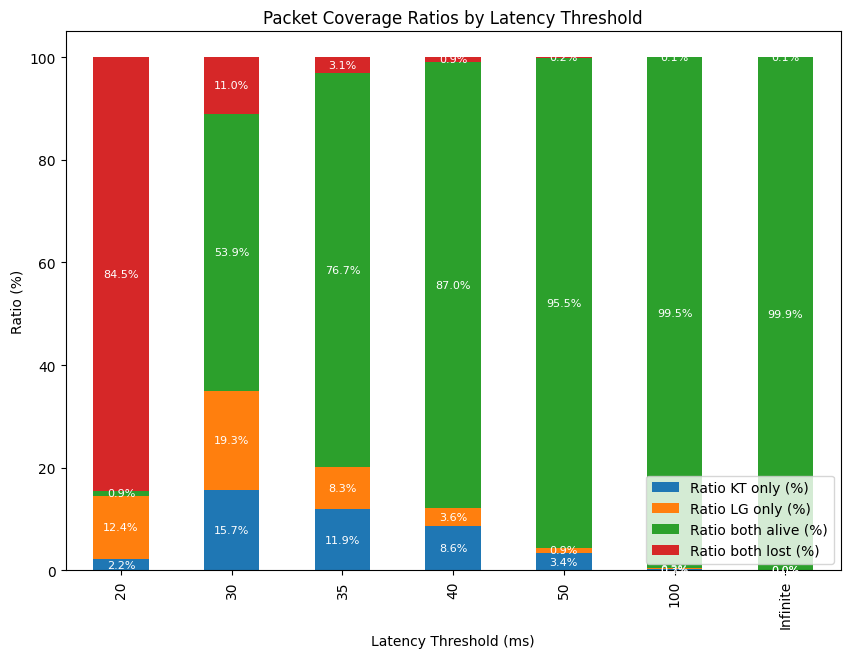

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 파일 읽기
kt_log_df = pd.read_csv(KT_LOG_FILEPATH, index_col=None)
lg_log_df = pd.read_csv(LG_LOG_FILEPATH, index_col=None)
sending_log_df = pd.read_csv(SENDING_LOG_FILEPATH, index_col=None)

# kt_log_df와 lg_log_df의 컬럼명에 접미사 추가 (단, 'sequence number'는 제외)
kt_log_df.rename(columns=lambda x: x + '_kt' if x != 'sequence_number' else x, inplace=True)
lg_log_df.rename(columns=lambda x: x + '_lg' if x != 'sequence_number' else x, inplace=True)

# sending_log_df를 기준으로 데이터 병합
merged_df = pd.merge(sending_log_df, kt_log_df, on="sequence_number", how="left")
merged_df = pd.merge(merged_df, lg_log_df, on="sequence_number", how="left")

# latency 임계값 리스트
thresholds = [20, 30, 35, 40, 50, 100, float('inf')]

# 결과를 저장할 리스트
results = []

for threshold in thresholds:
    # 각 경우에 대한 카운트 초기화
    count_kt_only = 0
    count_lg_only = 0
    count_both_alive = 0
    count_both_lost = 0

    # 각 행에 대해 패킷의 상태를 판단
    for index, row in merged_df.iterrows():
        # KT와 LG의 latency 값 가져오기
        kt_latency = row.get('network_latency_ms_kt')
        lg_latency = row.get('network_latency_ms_lg')

        # 패킷의 존재 여부 판단
        alive_kt = pd.notna(kt_latency) and kt_latency <= threshold
        alive_lg = pd.notna(lg_latency) and lg_latency <= threshold

        # 각 경우에 따라 카운트 증가
        if alive_kt and not alive_lg:
            count_kt_only += 1
        elif alive_lg and not alive_kt:
            count_lg_only += 1
        elif alive_kt and alive_lg:
            count_both_alive += 1
        else:
            count_both_lost += 1

    # 총 패킷 수 계산
    total_packets = count_kt_only + count_lg_only + count_both_alive + count_both_lost

    # 'both lost'를 제외한 총 패킷 수
    total_excl_both_lost = total_packets - count_both_lost

    # 'both lost'와 'both alive'를 제외한 총 패킷 수
    total_excl_both_lost_and_both_alive = total_packets - count_both_lost - count_both_alive

    # 각 경우에 대한 비율 계산 (퍼센트 형태)
    ratio_kt_only = (count_kt_only / total_packets * 100) if total_packets > 0 else 0
    ratio_lg_only = (count_lg_only / total_packets * 100) if total_packets > 0 else 0
    ratio_both_alive = (count_both_alive / total_packets * 100) if total_packets > 0 else 0
    ratio_both_lost = (count_both_lost / total_packets * 100) if total_packets > 0 else 0

    # 'both lost'를 제외한 비율 계산
    ratio_kt_only_excl_both_lost = (count_kt_only / total_excl_both_lost * 100) if total_excl_both_lost > 0 else 0
    ratio_lg_only_excl_both_lost = (count_lg_only / total_excl_both_lost * 100) if total_excl_both_lost > 0 else 0
    ratio_both_alive_excl_both_lost = (count_both_alive / total_excl_both_lost * 100) if total_excl_both_lost > 0 else 0

    # 'both lost'와 'both alive'를 제외한 비율 계산
    ratio_kt_only_excl_both_lost_and_both_alive = (count_kt_only / total_excl_both_lost_and_both_alive * 100) if total_excl_both_lost_and_both_alive > 0 else 0
    ratio_lg_only_excl_both_lost_and_both_alive = (count_lg_only / total_excl_both_lost_and_both_alive * 100) if total_excl_both_lost_and_both_alive > 0 else 0

    # 결과 저장
    results.append({
        'Latency Threshold (ms)': threshold if threshold != float('inf') else 'Infinite',
        'Packets covered by KT only': count_kt_only,
        'Packets covered by LG only': count_lg_only,
        'Packets where both alive': count_both_alive,
        'Packets where both lost': count_both_lost,
        'Total Packets': total_packets,
        'Ratio KT only (%)': f"{ratio_kt_only:.2f}%",
        'Ratio LG only (%)': f"{ratio_lg_only:.2f}%",
        'Ratio both alive (%)': f"{ratio_both_alive:.2f}%",
        'Ratio both lost (%)': f"{ratio_both_lost:.2f}%",
        'Ratio KT only (excluding both lost) (%)': f"{ratio_kt_only_excl_both_lost:.2f}%",
        'Ratio LG only (excluding both lost) (%)': f"{ratio_lg_only_excl_both_lost:.2f}%",
        'Ratio both alive (excluding both lost) (%)': f"{ratio_both_alive_excl_both_lost:.2f}%",
        'Ratio KT only (excluding both lost and both alive) (%)': f"{ratio_kt_only_excl_both_lost_and_both_alive:.2f}%",
        'Ratio LG only (excluding both lost and both alive) (%)': f"{ratio_lg_only_excl_both_lost_and_both_alive:.2f}%"
    })

# 결과를 데이터프레임으로 변환 후 출력
results_df = pd.DataFrame(results)

# 그래프 그리기
threshold_labels = [str(t) if t != float('inf') else 'Infinite' for t in thresholds]

# 비율 데이터만 선택
ratio_columns = ['Ratio KT only (%)', 'Ratio LG only (%)', 'Ratio both alive (%)', 'Ratio both lost (%)']
ratio_df = results_df[ratio_columns].copy()
ratio_df.index = threshold_labels

# 비율 값을 숫자로 변환
for col in ratio_columns:
    ratio_df[col] = ratio_df[col].str.rstrip('%').astype(float)

# 스택형 막대 그래프 생성
ax = ratio_df.plot(kind='bar', stacked=True, figsize=(10, 7))

# 각 바에 레이블 추가
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:
        ax.text(x + width / 2, y + height / 2, f'{height:.1f}%', ha='center', va='center', color='white', fontsize=8)

plt.xlabel('Latency Threshold (ms)')
plt.ylabel('Ratio (%)')
plt.title('Packet Coverage Ratios by Latency Threshold')
plt.legend(loc='best')
plt.savefig(f'{GRAPH_PATH}/Packet_coverage_ratio.png')
plt.show()


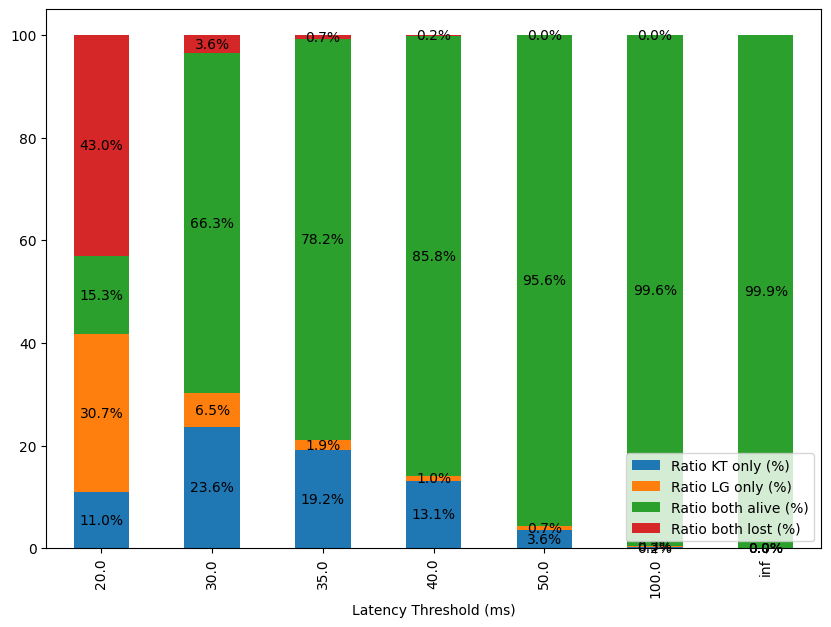

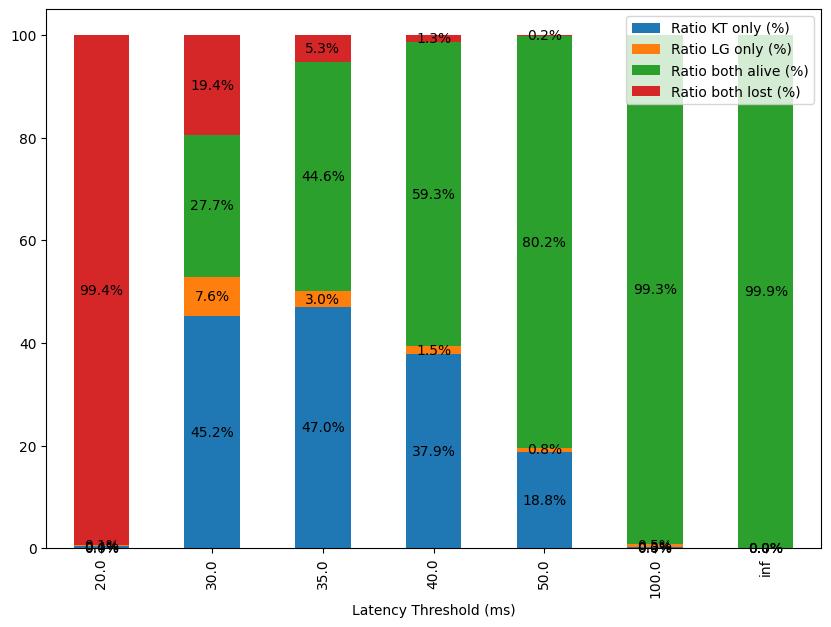

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# CSV 파일 읽기
kt_log_df = pd.read_csv(KT_LOG_FILEPATH, index_col=None)
lg_log_df = pd.read_csv(LG_LOG_FILEPATH, index_col=None)
sending_log_df = pd.read_csv(SENDING_LOG_FILEPATH, index_col=None)

# kt_log_df와 lg_log_df의 컬럼명에 접미사 추가
kt_log_df.rename(columns=lambda x: x + '_kt' if x != 'sequence_number' else x, inplace=True)
lg_log_df.rename(columns=lambda x: x + '_lg' if x != 'sequence_number' else x, inplace=True)

# 데이터 병합
merged_df = pd.merge(sending_log_df, kt_log_df, on="sequence_number", how="left")
merged_df = pd.merge(merged_df, lg_log_df, on="sequence_number", how="left")

# 📘 앞 20000개와 뒤 20000개로 나누기
first_20k_df = merged_df.iloc[:20000]
last_20k_df = merged_df.iloc[-20000:]

# 📘 그래프 생성 함수
def process_and_plot(merged_df, title_suffix):
    thresholds = [20, 30, 35, 40, 50, 100, float('inf')]
    results = []

    for threshold in thresholds:
        alive_kt = (merged_df['network_latency_ms_kt'].notna()) & (merged_df['network_latency_ms_kt'] <= threshold)
        alive_lg = (merged_df['network_latency_ms_lg'].notna()) & (merged_df['network_latency_ms_lg'] <= threshold)
        
        count_kt_only = ((alive_kt) & (~alive_lg)).sum()
        count_lg_only = ((alive_lg) & (~alive_kt)).sum()
        count_both_alive = ((alive_kt) & (alive_lg)).sum()
        count_both_lost = ((~alive_kt) & (~alive_lg)).sum()

        total_packets = count_kt_only + count_lg_only + count_both_alive + count_both_lost
        ratio_kt_only = (count_kt_only / total_packets * 100) if total_packets > 0 else 0

        # 📘 비율을 숫자 데이터로 저장
        results.append({
            'Latency Threshold (ms)': threshold, 
            'Ratio KT only (%)': ratio_kt_only, 
            'Ratio LG only (%)': (count_lg_only / total_packets * 100) if total_packets > 0 else 0, 
            'Ratio both alive (%)': (count_both_alive / total_packets * 100) if total_packets > 0 else 0, 
            'Ratio both lost (%)': (count_both_lost / total_packets * 100) if total_packets > 0 else 0
        })

    results_df = pd.DataFrame(results)

    # 📘 빈 데이터프레임 처리
    if results_df.empty:
        print(f"No data available for {title_suffix}")
        return

    ratio_df = results_df.set_index('Latency Threshold (ms)')

    # 📘 시각화 생성
    ax = ratio_df.plot(kind='bar', stacked=True, figsize=(10, 7))

    # 📘 각 막대 위에 비율 라벨 추가 (ax.bar_label 사용)
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', label_type='center')  # 스택된 각 막대의 중심에 비율 추가

    # 📘 그래프 저장
    plt.savefig(os.path.join(GRAPH_PATH, f'Packet_coverage_ratio_{title_suffix}.png'), dpi=300, bbox_inches='tight')
    plt.show()


# 📘 그래프 생성
process_and_plot(first_20k_df, 'First_20000')
process_and_plot(last_20k_df, 'Last_20000')


## Plot latency

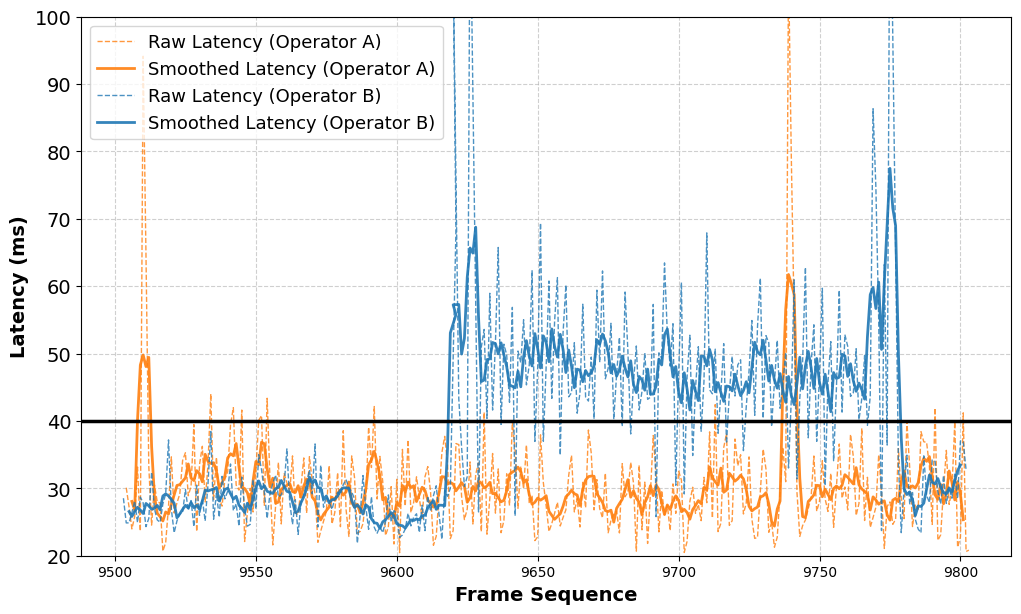

Raw + Smoothed data saved to latency_raw.csv


In [6]:
import pandas as pd
import matplotlib.pyplot as plt

BASE_FILEPATH = "/home/songmu/"
SERVER_FILEPATH = BASE_FILEPATH + "multipath/server/logs/2025_02_17_13_57/"
KT_LOG_FILEPATH = SERVER_FILEPATH + "kt_log.csv"
LG_LOG_FILEPATH = SERVER_FILEPATH + "lg_log.csv"
# COMBINE_LOG_FILEPATH = SERVER_FILEPATH + "combine_log.csv"

kt_log_df = pd.read_csv(KT_LOG_FILEPATH, index_col=None)
lg_log_df = pd.read_csv(LG_LOG_FILEPATH, index_col=None)
# combine_log_df = pd.read_csv(COMBINE_LOG_FILEPATH, index_col=None)

start = 9500
end = 9800

kt_sequence_numbers = kt_log_df['sequence_number'][start:end]
kt_latencies = kt_log_df['network_latency_ms'][start:end]

lg_sequence_numbers = lg_log_df['sequence_number'][start:end]
lg_latencies = lg_log_df['network_latency_ms'][start:end]

# combine_sequence_numbers = combine_log_df['sequence_number'][start:end]
# combine_latencies = combine_log_df['network_latency_ms'][start:end]

# 이동평균 (window 5)
window_size = 5
lg_latencies_smooth = lg_latencies.rolling(window=window_size, center=True).mean()
kt_latencies_smooth = kt_latencies.rolling(window=window_size, center=True).mean()
# 색상 정의
lg_raw_color      = '#1f77b4'  # LG 원본: 파란
lg_smooth_color   = '#1f77b4'  # LG 스무스: 파란
kt_raw_color      = '#ff7f0e'  # KT 원본: 주황
kt_smooth_color   = '#ff7f0e'  # KT 스무스: 주황

plt.figure(figsize=(12, 7))

# 1. 원본 데이터 (LG / KT) — 회색이 아니라 각각의 색상 + 점선
# 2. 이동평균 데이터 (LG / KT) — 실선
# Operator A - LG, Operator B - KT

plt.plot(kt_sequence_numbers, kt_latencies,
         color=kt_raw_color, linestyle='--', linewidth=1.0, alpha=0.8,
         label='Raw Latency (Operator A)')

plt.plot(kt_sequence_numbers, kt_latencies_smooth,
         color=kt_smooth_color, linestyle='-', linewidth=2.0, alpha=0.9,
         label='Smoothed Latency (Operator A)')
plt.plot(lg_sequence_numbers, lg_latencies,
         color=lg_raw_color, linestyle='--', linewidth=1.0, alpha=0.8,
         label='Raw Latency (Operator B)')

plt.plot(lg_sequence_numbers, lg_latencies_smooth,
         color=lg_smooth_color, linestyle='-', linewidth=2.0, alpha=0.9,
         label='Smoothed Latency (Operator B)')




# y=40에 검정색 굵은 실선 추가
plt.axhline(y=40, color='black', linestyle='-', linewidth=2.5)

# y축 범위 설정
plt.ylim(20, 100)

# y축에 30, 40, 50 강조
current_yticks = plt.yticks()[0]
new_yticks = list(current_yticks) + [30, 40, 50]
new_yticks = sorted(set(new_yticks))
plt.yticks(new_yticks)

# 레이블, 범례, 그리드
plt.xlabel('Frame Sequence', fontweight = 'bold', fontsize = 14)
plt.ylabel('Latency (ms)', fontweight = 'bold', fontsize = 14)
# plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tick_params(axis='y', labelsize=14)

# 범례 추가
plt.legend(loc='upper left', fontsize=13)

# 그래프 저장
plt.savefig('latency.png', dpi=300, bbox_inches='tight')

# 출력
plt.show()

# 9500~9800 구간 Raw + Smoothed 데이터 모두 CSV로 저장
combined_data_df = pd.DataFrame({
    'lg_sequence_number': lg_sequence_numbers.values,
    'lg_raw_latency_ms': lg_latencies.values,
    'lg_smoothed_latency_ms': lg_latencies_smooth.values,
    'kt_sequence_number': kt_sequence_numbers.values,
    'kt_raw_latency_ms': kt_latencies.values,
    'kt_smoothed_latency_ms': kt_latencies_smooth.values
})

combined_csv_path = 'latency_raw.csv'
combined_data_df.to_csv(combined_csv_path, index=False)

print(f"Raw + Smoothed data saved to {combined_csv_path}")


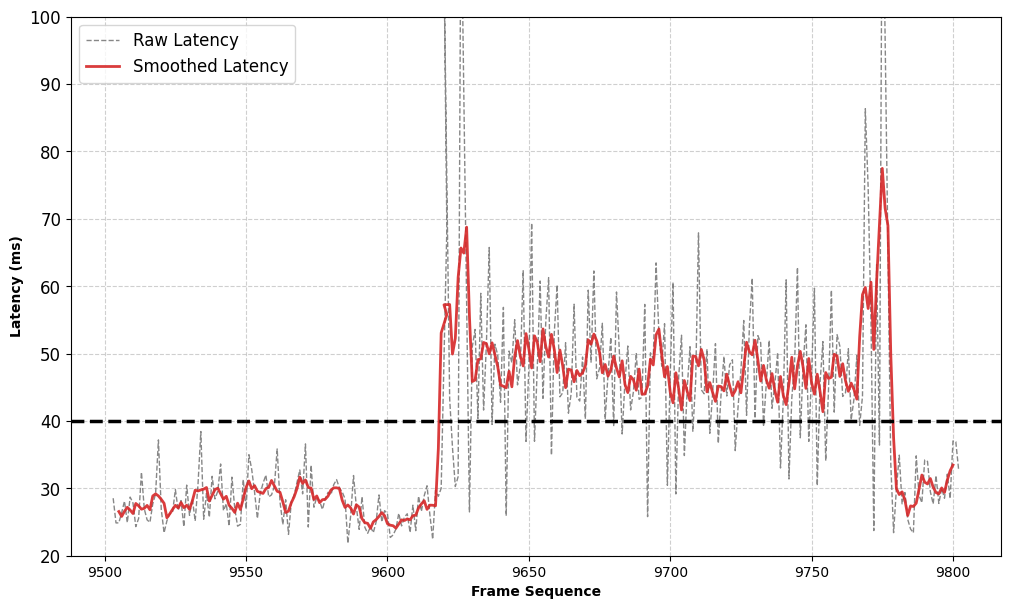

Raw + Smoothed data saved to /home/songmu/Pictures/latency_raw_and_smoothed_9500_9800.csv


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

BASE_FILEPATH = "/home/songmu/"
SERVER_FILEPATH = BASE_FILEPATH + "multipath/server/logs/2025_02_17_13_57/"
LG_LOG_FILEPATH = SERVER_FILEPATH + "lg_log.csv"

# 데이터 읽기
lg_log_df = pd.read_csv(LG_LOG_FILEPATH, index_col=None)

# 9500~9800 사이만 사용
start = 9500
end = 9800

lg_sequence_numbers = lg_log_df['sequence_number'][start:end]
lg_latencies = lg_log_df['network_latency_ms'][start:end]

# 이동평균 (window 5)
window_size = 5
lg_latencies_smooth = lg_latencies.rolling(window=window_size, center=True).mean()

plt.figure(figsize=(12, 7))

# 1. 원본 데이터 (배경용: 짙은 회색 점선) + Legend
plt.plot(lg_sequence_numbers, lg_latencies,
         color='dimgray', linestyle='--', linewidth=1.0, alpha=0.8,
         label='Raw Latency')

# 2. 이동평균 데이터 (강조: 빨간 실선) + Legend
plt.plot(lg_sequence_numbers, lg_latencies_smooth,
         color='#d62728', linestyle='-', linewidth=2.0, alpha=0.9,
         label='Smoothed Latency')

# y=40에 검정색 굵은 점선 추가
plt.axhline(y=40, color='black', linestyle='--', linewidth=2.5)

# y축 설정
plt.ylim(20, 100)
current_yticks = plt.yticks()[0]
new_yticks = list(current_yticks) + [30, 40, 50]
new_yticks = sorted(set(new_yticks))
plt.yticks(new_yticks)

# Label, Grid
plt.xlabel('Frame Sequence', fontweight='bold')
plt.ylabel('Latency (ms)', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)

# 범례 추가
plt.legend(loc='upper left', fontsize=12)
plt.tick_params(axis='y', labelsize=12)

# 그래프 저장
plt.savefig('/home/songmu/Pictures/latency_smooth_final_with_legend.png', dpi=300, bbox_inches='tight')
plt.show()

# 9500~9800 구간 Raw + Smoothed 데이터 모두 CSV로 저장
combined_data_df = pd.DataFrame({
    'sequence_number': lg_sequence_numbers.values,
    'raw_latency_ms': lg_latencies.values,
    'smoothed_latency_ms': lg_latencies_smooth.values
})

combined_csv_path = '/home/songmu/Pictures/latency_raw_and_smoothed_9500_9800.csv'
combined_data_df.to_csv(combined_csv_path, index=False)

print(f"Raw + Smoothed data saved to {combined_csv_path}")


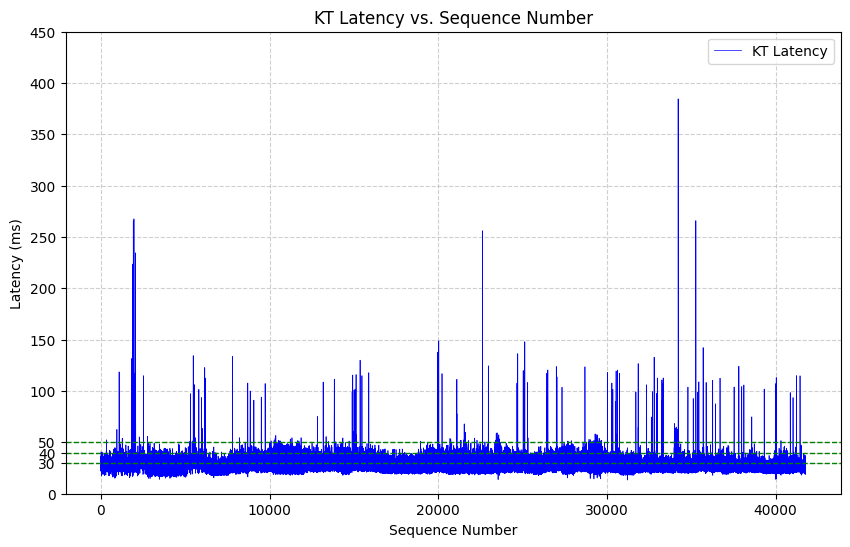

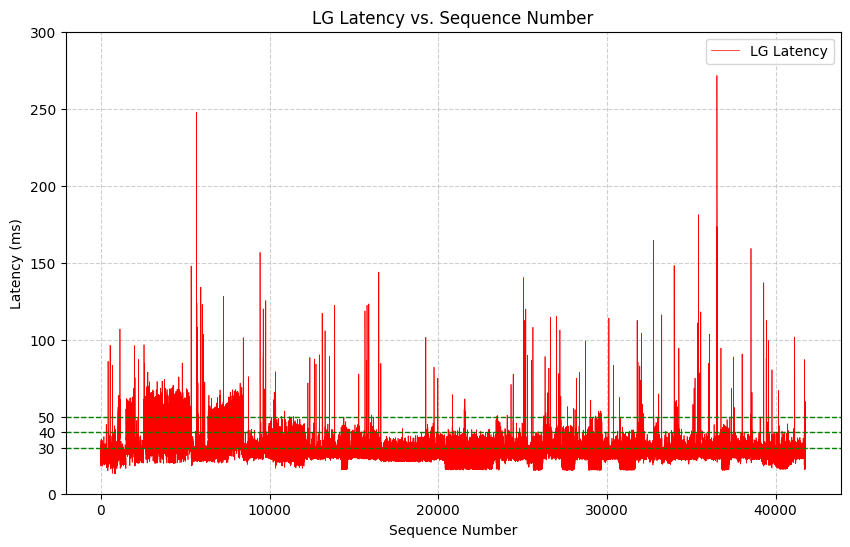

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# CSV 파일 읽기
kt_log_df = pd.read_csv(KT_LOG_FILEPATH, index_col=None)
lg_log_df = pd.read_csv(LG_LOG_FILEPATH, index_col=None)

# 'sequence_number'와 'network_latency_ms' 데이터를 추출
kt_sequence_numbers = kt_log_df['sequence_number']
kt_latencies = kt_log_df['network_latency_ms']

lg_sequence_numbers = lg_log_df['sequence_number']
lg_latencies = lg_log_df['network_latency_ms']

# KT 그래프 생성
plt.figure(figsize=(10, 6))  # 그래프 크기 설정
plt.plot(kt_sequence_numbers, kt_latencies, label='KT Latency', color='blue', linestyle='-', linewidth=0.5)
plt.ylim(bottom=0)  # y축의 최소값을 0으로 설정

# y축에 30, 40, 50 추가
current_yticks = plt.yticks()[0]  # 현재 y축의 위치 가져오기
new_yticks = list(current_yticks) + [30, 40, 50]  # 30, 40, 50 추가
new_yticks = sorted(set(new_yticks))  # 중복 제거 후 정렬
plt.yticks(new_yticks)  # 새로운 y축 라벨로 업데이트

# y축이 30, 40, 50일 때 초록색 가로선 추가
highlight_values = [30, 40, 50]
for val in highlight_values:
    plt.axhline(y=val, color='green', linestyle='--', linewidth=1)  # y축에 대한 가로선 추가

# KT 그래프 레이블 추가
plt.xlabel('Sequence Number')
plt.ylabel('Latency (ms)')
plt.title('KT Latency vs. Sequence Number')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# 그래프 저장
kt_graph_path = os.path.join(GRAPH_PATH, 'kt_latency.png')
plt.savefig(kt_graph_path, dpi=300, bbox_inches='tight')

# 그래프 출력
plt.show()

# LG 그래프 생성
plt.figure(figsize=(10, 6))  # 그래프 크기 설정
plt.plot(lg_sequence_numbers, lg_latencies, label='LG Latency', color='red', linestyle='-', linewidth=0.5)
plt.ylim(bottom=0)  # y축의 최소값을 0으로 설정

# y축에 30, 40, 50 추가
current_yticks = plt.yticks()[0]  # 현재 y축의 위치 가져오기
new_yticks = list(current_yticks) + [30, 40, 50]  # 30, 40, 50 추가
new_yticks = sorted(set(new_yticks))  # 중복 제거 후 정렬
plt.yticks(new_yticks)  # 새로운 y축 라벨로 업데이트

# y축이 30, 40, 50일 때 초록색 가로선 추가
for val in highlight_values:
    plt.axhline(y=val, color='green', linestyle='--', linewidth=1)  # y축에 대한 가로선 추가

# LG 그래프 레이블 추가
plt.xlabel('Sequence Number')
plt.ylabel('Latency (ms)')
plt.title('LG Latency vs. Sequence Number')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# 그래프 저장
lg_graph_path = os.path.join(GRAPH_PATH, 'lg_latency.png')
plt.savefig(lg_graph_path, dpi=300, bbox_inches='tight')

# 그래프 출력
plt.show()


# plot loss

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# 설정된 경로 및 파일들
file_names = ["kt_log.csv", "lg_log.csv", "combine_log.csv"]

# 설정할 delay thresholds
delay_thresholds = [20, 30, 40, 50, 100]

# 결과를 저장할 폴더
output_folder = GRAPH_PATH

# 그래프 생성 함수
def create_graph(file_path, delay_thresholds):
    # 파일 읽기
    df = pd.read_csv(file_path)
    file_name = os.path.basename(file_path).split('.')[0]

    for threshold in delay_thresholds:
        # 지연 시간 비교: 작으면 1, 크면 0
        df[f"latency_below_{threshold}"] = df["network_latency_ms"] <= threshold

        # 그래프 생성
        plt.figure(figsize=(10, 6))
        plt.plot(df["sequence_number"], 
                 df[f"latency_below_{threshold}"], 
                 marker='o', 
                 linestyle='None',  # 선 제거
                 markersize=0.1,      # 마커 크기 조정
                 label=f"Threshold: {threshold}ms")
        plt.xlabel("Sequence Number")
        plt.ylabel(f"Latency ≤ {threshold}ms (1: Yes, 0: No)")
        plt.title(f"Network Latency Comparison for {file_name} (Threshold {threshold}ms)")
        plt.legend()
        plt.grid()

        # 그래프 저장
        output_path = os.path.join(output_folder, f"{file_name}_latency_{threshold}ms.png")
        plt.savefig(output_path)
        plt.close()
        print(f"Graph saved: {output_path}")

# 각 파일에 대해 그래프 생성
for file_name in file_names:
    file_path = os.path.join(SERVER_FILEPATH, file_name)
    create_graph(file_path, delay_thresholds)

print("All graphs have been generated and saved.")


Graph saved: /home/songmu/multipath/server/logs/2024_12_10_16_45/graphs/kt_log_latency_20ms.png
Graph saved: /home/songmu/multipath/server/logs/2024_12_10_16_45/graphs/kt_log_latency_30ms.png
Graph saved: /home/songmu/multipath/server/logs/2024_12_10_16_45/graphs/kt_log_latency_40ms.png
Graph saved: /home/songmu/multipath/server/logs/2024_12_10_16_45/graphs/kt_log_latency_50ms.png
Graph saved: /home/songmu/multipath/server/logs/2024_12_10_16_45/graphs/kt_log_latency_100ms.png
Graph saved: /home/songmu/multipath/server/logs/2024_12_10_16_45/graphs/lg_log_latency_20ms.png
Graph saved: /home/songmu/multipath/server/logs/2024_12_10_16_45/graphs/lg_log_latency_30ms.png
Graph saved: /home/songmu/multipath/server/logs/2024_12_10_16_45/graphs/lg_log_latency_40ms.png
Graph saved: /home/songmu/multipath/server/logs/2024_12_10_16_45/graphs/lg_log_latency_50ms.png
Graph saved: /home/songmu/multipath/server/logs/2024_12_10_16_45/graphs/lg_log_latency_100ms.png
Graph saved: /home/songmu/multipath/se

## frame number 생성 (client file)

In [6]:
import os
import shutil

# 원본 frames 폴더 경로
frames_folder = os.path.expanduser(f"{CLIENT_FILEPATH}frames")
# 새로 생성할 frames_with_sequence 폴더 경로
destination_folder = os.path.expanduser(f"{CLIENT_FILEPATH}frames_with_sequence")

# frames_with_sequence 폴더가 없으면 생성
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# frames 폴더 내의 파일들을 가져옴
files = [f for f in os.listdir(frames_folder) if f.endswith(".png")]

# 파일들을 타임스탬프 기준으로 정렬
files.sort(key=lambda x: int(x.split('.')[0]))

sequence_number = 0
final_sequence_number = len(files) - 1 # 0부터 시작

# 파일들을 순서대로 복사하며 이름 변경
for file_name in files:
    if sequence_number <= final_sequence_number:
        timestamp = file_name.split('.')[0]
        new_file_name = f"{sequence_number}_{timestamp}.png"
        src_path = os.path.join(frames_folder, file_name)
        dst_path = os.path.join(destination_folder, new_file_name)
        shutil.copy(src_path, dst_path)
        sequence_number += 1

print("Files have been successfully copied and renamed.")


Files have been successfully copied and renamed.


### Message size <-> Network latency

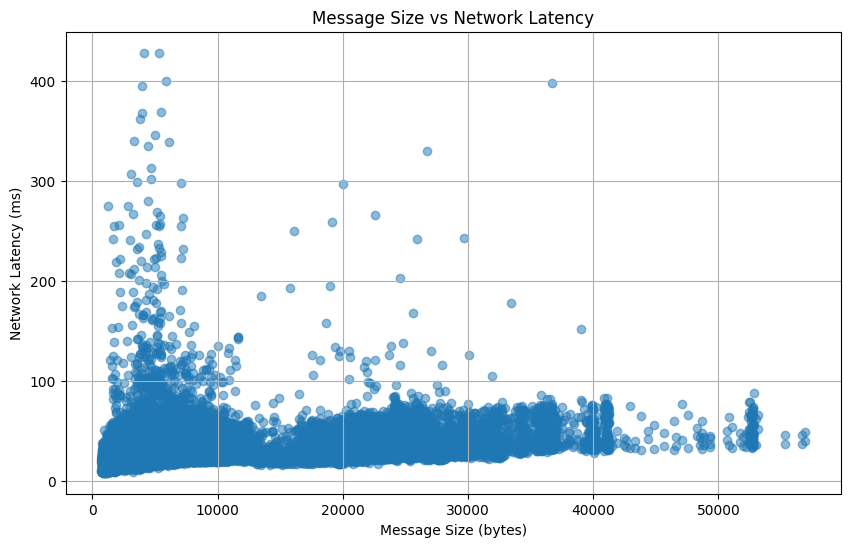

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os


def plot_message_size_vs_latency(kt_log_df, lg_log_df):
    # Combine the data frames
    combined_df = pd.concat([kt_log_df, lg_log_df], ignore_index=True)
    
    # Ensure the required columns exist
    if 'message_size' not in combined_df.columns or 'network_latency_ms' not in combined_df.columns:
        print("Required columns are missing in the data frames.")
        return
    
    # Extract the required columns
    message_sizes = combined_df['message_size']
    latencies = combined_df['network_latency_ms']
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(message_sizes, latencies, alpha=0.5)
    plt.title('Message Size vs Network Latency')
    plt.xlabel('Message Size (bytes)')
    plt.ylabel('Network Latency (ms)')
    plt.grid(True)
    plt.savefig(f'{GRAPH_PATH}/message_size_vs_latency.png')
    plt.show()


plot_message_size_vs_latency(kt_log_df, lg_log_df)


Count: 41750
Mean latency: 24.37 ms
Standard deviation: 4.80 ms
Standard error: 0.02 ms
95% CI margin of error: ±0.05 ms
95% CI: [24.32, 24.42] ms


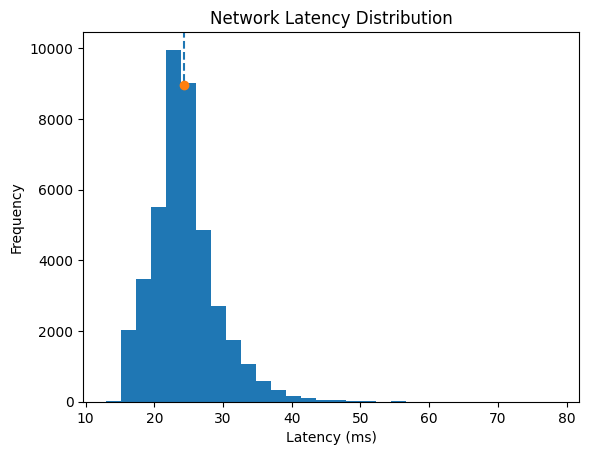

In [1]:
BASE_FILEPATH = "/home/songmu/"
SERVER_FILEPATH = BASE_FILEPATH + "multipath/server/logs/2025_02_17_13_57/"
LG_LOG_FILEPATH = SERVER_FILEPATH + "lg_log.csv"
KT_LOG_FILEPATH = SERVER_FILEPATH + "kt_log.csv"
COMBINE_LOG_FILEPATH = SERVER_FILEPATH + "combine_log.csv"


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Replace with your CSV file path
file_path = COMBINE_LOG_FILEPATH
df = pd.read_csv(file_path)

# Extract and clean the latency data
latencies = df['network_latency_ms'].dropna()

# Calculate statistics
n = len(latencies)
mean_latency = latencies.mean()
std_latency = latencies.std(ddof=1)
std_error = std_latency / np.sqrt(n)
confidence_level = 1.96  # z-score for 95% confidence
margin_error = confidence_level * std_error

# Print results
print(f'Count: {n}')
print(f'Mean latency: {mean_latency:.2f} ms')
print(f'Standard deviation: {std_latency:.2f} ms')
print(f'Standard error: {std_error:.2f} ms')
print(f'95% CI margin of error: ±{margin_error:.2f} ms')
print(f'95% CI: [{mean_latency - margin_error:.2f}, {mean_latency + margin_error:.2f}] ms')

# Plot histogram with mean and confidence interval
plt.figure()
counts, bins, patches = plt.hist(latencies, bins=30)
max_count = counts.max()
plt.axvline(mean_latency, linestyle='dashed')
plt.errorbar(x=mean_latency, y=max_count * 0.9, xerr=margin_error, fmt='o')
plt.title('Network Latency Distribution')
plt.xlabel('Latency (ms)')
plt.ylabel('Frequency')
plt.show()
